##MGMT 472 Term Final Project
Ethan Quinn, Jack Strabala, Tomas Turner

For our final project, we decided

In [1]:
!pip install google-cloud-bigquery pandas-gbq -q


In [2]:
from google.colab import auth
auth.authenticate_user()


In [3]:
from google.cloud import bigquery

project_id = "mgmt-467-35946"
client = bigquery.Client(project=project_id)

query = """
    SELECT *
    FROM `mgmt-467-35946.hotel_booking.hotel_bookings`
"""

df = client.query(query).to_dataframe()

df.head(), df.shape



(          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
 0  Resort Hotel            0        342               2015               July   
 1  Resort Hotel            0        737               2015               July   
 2  Resort Hotel            0          7               2015               July   
 3  Resort Hotel            0         13               2015               July   
 4  Resort Hotel            0         14               2015               July   
 
    arrival_date_week_number  arrival_date_day_of_month  \
 0                        27                          1   
 1                        27                          1   
 2                        27                          1   
 3                        27                          1   
 4                        27                          1   
 
    stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
 0                        0                     0       2  ...    No D

In [4]:
import pandas as pd

# df is your raw table from BigQuery
# df = client.query("SELECT * FROM `mgmt-467-35946.hotel_booking.hotel_bookings`").to_dataframe()

# 0. Filter to only Portugal bookings
df = df[df["country"] == "PRT"].copy()

# 1. Map month names → month numbers
month_map = {
    "January": 1, "February": 2, "March": 3, "April": 4,
    "May": 5, "June": 6, "July": 7, "August": 8,
    "September": 9, "October": 10, "November": 11, "December": 12
}
df["arrival_month_num"] = df["arrival_date_month"].map(month_map)

# 2. Build a proper arrival_date column
df["arrival_date"] = pd.to_datetime({
    "year": df["arrival_date_year"],
    "month": df["arrival_month_num"],
    "day": df["arrival_date_day_of_month"]
})

# 3. Parse reservation_status_date
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])

# 4. Derived feature: total number of guests
df["children"] = df["children"].fillna(0)
df["total_guests"] = df["adults"] + df["children"] + df["babies"]

# 5. Data-quality filters (use adr before we drop it)
df_curated = df[(df["total_guests"] > 0) & (df["adr"] >= 0)].copy()

# 6. Drop helper and unwanted columns
cols_to_drop = ["arrival_month_num", "company", "agent", "adr", "meal"]
df_curated.drop(columns=cols_to_drop, inplace=True, errors="ignore")

# The variable 'cols' was not defined, leading to a NameError.
# If you intended to select a specific subset of columns here, you need to define 'cols' as a list of column names.
# For now, this line is commented out to resolve the error.
# df_curated = df_curated[cols].copy()

# Take a look
df_curated.head(), df_curated.shape

(          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
 0  Resort Hotel            0        342               2015               July   
 1  Resort Hotel            0        737               2015               July   
 6  Resort Hotel            0          0               2015               July   
 7  Resort Hotel            0          9               2015               July   
 8  Resort Hotel            1         85               2015               July   
 
    arrival_date_week_number  arrival_date_day_of_month  \
 0                        27                          1   
 1                        27                          1   
 6                        27                          1   
 7                        27                          1   
 8                        27                          1   
 
    stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
 0                        0                     0       2  ...   
 1                

In [5]:
import pandas_gbq

dataset_id = "hotel_booking"
table_id = "hotel_bookings_curated"
full_table_id = f"{project_id}.{dataset_id}.{table_id}"

pandas_gbq.to_gbq(
    df_curated,
    full_table_id,
    project_id=project_id,
    if_exists="replace"  # or "fail" if you don't want to overwrite
)


100%|██████████| 1/1 [00:00<00:00, 9425.40it/s]


In [6]:
from google.cloud import bigquery

# Assuming project_id is already defined from previous cells
# If not, uncomment and define it:
# project_id = "mgmt-467-35946"

client = bigquery.Client(project=project_id)

dataset_id = "hotel_booking"
table_name = "hotel_bookings_curated_with_weather"
full_table_id = f"{project_id}.{dataset_id}.{table_name}"

query = f"""
    SELECT *
    FROM `{full_table_id}`
"""

df_weather = client.query(query).to_dataframe()

print(f"DataFrame '{table_name}' loaded successfully. Head and shape are:")
df_weather.head(), df_weather.shape

DataFrame 'hotel_bookings_curated_with_weather' loaded successfully. Head and shape are:


(        hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
 0  City Hotel            0          0               2016           February   
 1  City Hotel            0          2               2016              March   
 2  City Hotel            0          7               2016              March   
 3  City Hotel            1          5               2016              April   
 4  City Hotel            0          5               2016              April   
 
    arrival_date_week_number  arrival_date_day_of_month  \
 0                         8                         15   
 1                        12                         16   
 2                        13                         21   
 3                        15                          4   
 4                        15                          5   
 
    stays_in_weekend_nights  stays_in_week_nights  adults  ...  latitude  \
 0                        1                     3       1  ...     38.72   
 1        

/tmp/ipython-input-2238500282.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_cancellation_summary = df_weather.groupby(temp_bins)[['is_canceled']].mean().reset_index()


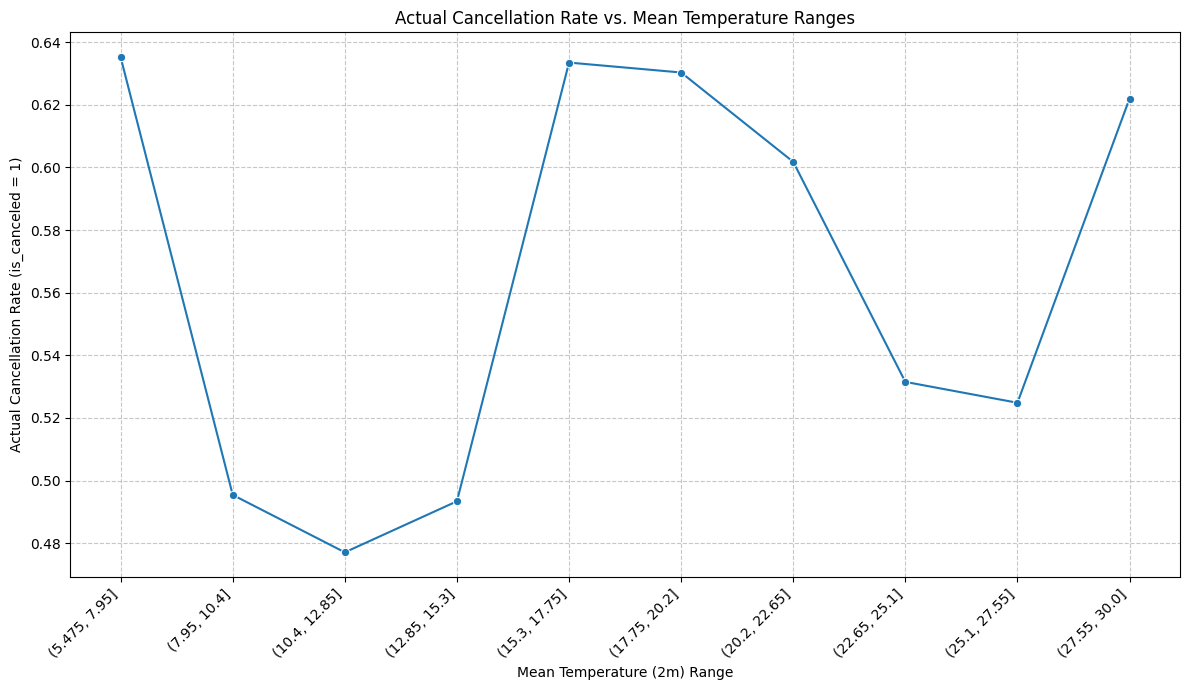

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for data manipulation

# Ensure df_weather is available (assuming it's loaded in a previous cell)
# If df_weather is not defined, you would need to run the cell that defines it first (e.g., cell 8tfCC0P8rN_M)

# Create temperature bins and calculate actual average cancellation rate
# Define bins for temperature
temp_bins = pd.cut(
    df_weather['temperature_2m_mean'],
    bins=10, # Create 10 bins for temperature
    include_lowest=True
)

# Group by temperature bins and calculate the mean actual cancellation (0 or 1)
# The mean of a binary variable gives the proportion of '1's, which is the cancellation rate
temp_cancellation_summary = df_weather.groupby(temp_bins)[['is_canceled']].mean().reset_index()
temp_cancellation_summary.columns = ['Temperature Range', 'Actual Cancellation Rate']

# Visualize the relationship between actual cancellation rate and mean temperature
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=temp_cancellation_summary['Temperature Range'].astype(str), # Convert intervals to strings
    y='Actual Cancellation Rate',
    data=temp_cancellation_summary,
    marker='o' # Add markers for data points
)
plt.title('Actual Cancellation Rate vs. Mean Temperature Ranges')
plt.xlabel('Mean Temperature (2m) Range')
plt.ylabel('Actual Cancellation Rate (is_canceled = 1)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

/tmp/ipython-input-3218812012.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_cancellation_summary = df_weather.groupby(temp_bins)[['is_canceled']].mean().reset_index()
/tmp/ipython-input-3218812012.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp_cancellation_summary['Count'] = df_weather.groupby(temp_bins).size().values
/tmp/ipython-input-3218812012.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Summary of Actual Cancellation Rate by Mean Temperature Ranges:
  Temperature Range  Actual Cancellation Rate  Count
0     (5.475, 7.95]                   0.63522    159
1      (7.95, 10.4]                  0.495413   1853
2     (10.4, 12.85]                   0.47708   6479
3     (12.85, 15.3]                  0.493381   8612
4     (15.3, 17.75]                   0.63347   6818
5     (17.75, 20.2]                    0.6303  11439
6     (20.2, 22.65]                  0.601765   8839
7     (22.65, 25.1]                  0.531505   3063
8     (25.1, 27.55]                  0.524838    926
9     (27.55, 30.0]                  0.621993    291

Summary of Actual Cancellation Rate by Precipitation Ranges:
  Precipitation Range  Actual Cancellation Rate  Count
0       (-0.034, 3.3]                  0.568159  42166
1          (3.3, 6.6]                  0.620526   2319
2          (6.6, 9.9]                  0.527789   2429
3         (9.9, 13.2]                  0.501031    485
4        (13.2,

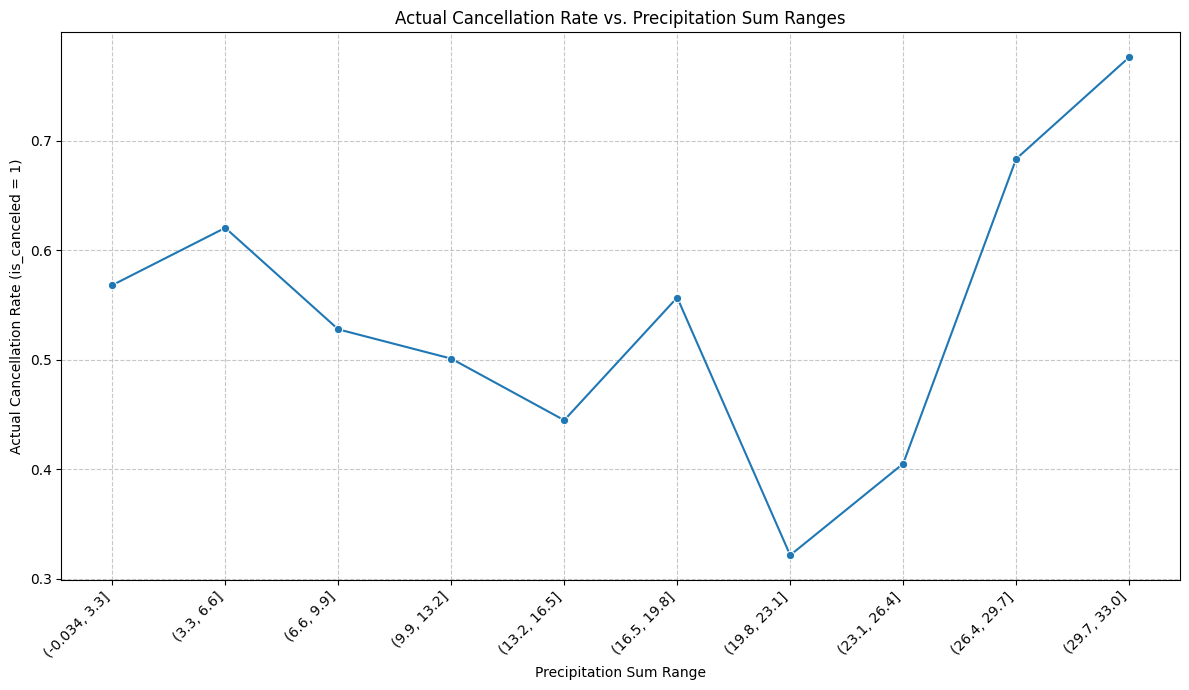

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create temperature bins and calculate actual average cancellation rate
# Define bins for temperature
temp_bins = pd.cut(
    df_weather['temperature_2m_mean'],
    bins=10, # Create 10 bins for temperature
    include_lowest=True
)

# Group by temperature bins and calculate the mean actual cancellation (0 or 1)
# The mean of a binary variable gives the proportion of '1's, which is the cancellation rate
temp_cancellation_summary = df_weather.groupby(temp_bins)[['is_canceled']].mean().reset_index()
temp_cancellation_summary.columns = ['Temperature Range', 'Actual Cancellation Rate']

# Also count the number of observations in each bin for context
temp_cancellation_summary['Count'] = df_weather.groupby(temp_bins).size().values

print("\nSummary of Actual Cancellation Rate by Mean Temperature Ranges:")
print(temp_cancellation_summary)

# --- New Analysis for Precipitation ---

# Create precipitation bins and calculate actual average cancellation rate
# Define bins for precipitation sum
precip_bins = pd.cut(
    df_weather['precipitation_sum'],
    bins=10, # Create 10 bins for precipitation
    include_lowest=True
)

# Group by precipitation bins and calculate the mean actual cancellation rate
precip_cancellation_summary = df_weather.groupby(precip_bins)[['is_canceled']].mean().reset_index()
precip_cancellation_summary.columns = ['Precipitation Range', 'Actual Cancellation Rate']

# Also count the number of observations in each bin for context
precip_cancellation_summary['Count'] = df_weather.groupby(precip_bins).size().values

print("\nSummary of Actual Cancellation Rate by Precipitation Ranges:")
print(precip_cancellation_summary)

# Visualize the relationship between actual cancellation rate and precipitation sum
plt.figure(figsize=(12, 7))
sns.lineplot(
    x=precip_cancellation_summary['Precipitation Range'].astype(str), # Convert intervals to strings
    y='Actual Cancellation Rate',
    data=precip_cancellation_summary,
    marker='o' # Add markers for data points
)
plt.title('Actual Cancellation Rate vs. Precipitation Sum Ranges')
plt.xlabel('Precipitation Sum Range')
plt.ylabel('Actual Cancellation Rate (is_canceled = 1)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

# Task
Modify the BigQuery ML logistic regression model defined in cell `22e7cc3a` to use only `is_canceled` as the label and `temperature_2m_mean`, `precipitation_sum`, `windspeed_10m_max`, and `weathercode` as input features. After retraining, re-evaluate the model's performance using `ML.EVALUATE` and `ML.EXPLAIN_PREDICT` queries.

## Modify BQML model features

### Subtask:
Update the `create_model_query` in cell `22e7cc3a` to exclusively use `is_canceled` as the label and `temperature_2m_mean`, `precipitation_sum`, `windspeed_10m_max`, and `weathercode` as input features for the BigQuery ML logistic regression model. This will retrain the model with only weather-related factors.


**Reasoning**:
I will update the `create_model_query` in cell `22e7cc3a` to use only `is_canceled` as the label and `temperature_2m_mean`, `precipitation_sum`, `windspeed_10m_max`, and `weathercode` as input features for the BigQuery ML logistic regression model.



In [9]:
from google.cloud import bigquery

# 1. Define the following variables
PROJECT_ID = "mgmt-467-35946"
DATASET_ID = "hotel_booking"
TABLE_ID = "hotel_bookings_curated_with_weather"
MODEL_ID = "hotel_cancellation_prediction_model"

client = bigquery.Client(project=PROJECT_ID)

# 2. Construct a SQL query to create or replace a BigQuery ML model
create_model_query = f"""
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET_ID}.{MODEL_ID}`
OPTIONS(
    model_type='LOGISTIC_REG',
    input_label_cols=['is_canceled'],
    enable_global_explain=TRUE,
    max_iterations=10
)
AS
SELECT
    is_canceled,
    temperature_2m_mean,
    precipitation_sum,
    windspeed_10m_max,
    weathercode
FROM
    `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
WHERE
    is_canceled IS NOT NULL
"""

# 4. Execute this SQL query and ensure it completes successfully
print(f"Starting BigQuery ML model training for {MODEL_ID}...")
query_job = client.query(create_model_query)
query_job.result() # Wait for the job to complete

# 5. Print a confirmation message
print(f"BigQuery ML model '{MODEL_ID}' training completed successfully.")

Starting BigQuery ML model training for hotel_cancellation_prediction_model...
BigQuery ML model 'hotel_cancellation_prediction_model' training completed successfully.


**Reasoning**:
The subtask requires re-evaluating the model's performance using `ML.EVALUATE` and `ML.EXPLAIN_PREDICT` queries after the model has been retrained. The necessary code for this is already present in cell `UyLWyeIevHnI`, so I will re-execute that cell.



In [10]:
from google.cloud import bigquery

# Ensure PROJECT_ID, DATASET_ID, MODEL_ID are defined from previous cells
# If not, uncomment and define them:
# PROJECT_ID = "mgmt-467-35946"
# DATASET_ID = "hotel_booking"
# MODEL_ID = "hotel_cancellation_prediction_model"
# TABLE_ID = "hotel_bookings_curated_with_weather"

client = bigquery.Client(project=PROJECT_ID)

# --- ML.EVALUATE --- #
print(f"Evaluating BigQuery ML model '{MODEL_ID}'...")
evaluate_query = f"""
    SELECT
      *
    FROM
      ML.EVALUATE(MODEL `{PROJECT_ID}.{DATASET_ID}.{MODEL_ID}`)
"""
evaluation_results = client.query(evaluate_query).to_dataframe()
print("ML.EVALUATE Results:")
print(evaluation_results)

# --- ML.EXPLAIN_PREDICT --- #
print(f"\nGenerating ML.EXPLAIN_PREDICT for model '{MODEL_ID}'...")
explain_predict_query = f"""
    SELECT
      *
    FROM
      ML.EXPLAIN_PREDICT(MODEL `{PROJECT_ID}.{DATASET_ID}.{MODEL_ID}`,
        (SELECT *
         FROM `{PROJECT_ID}.{DATASET_ID}.{TABLE_ID}`
         WHERE is_canceled IS NOT NULL
         LIMIT 100)) # Limiting for demonstration purposes
"""
explain_predict_results = client.query(explain_predict_query).to_dataframe()
print("ML.EXPLAIN_PREDICT Results (first 5 rows):")
print(explain_predict_results.head())

print("\nModel evaluation and explainable predictions completed.")

Evaluating BigQuery ML model 'hotel_cancellation_prediction_model'...
ML.EVALUATE Results:
   precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.831176  0.843405  0.811423  0.837246  0.376042  0.907119

Generating ML.EXPLAIN_PREDICT for model 'hotel_cancellation_prediction_model'...
ML.EXPLAIN_PREDICT Results (first 5 rows):
   predicted_is_canceled  probability  \
0                      0     0.502999   
1                      1     0.504152   
2                      1     0.503211   
3                      1     0.501921   
4                      1     0.500946   

                            top_feature_attributions  \
0  [{'feature': 'temperature_2m_mean', 'attributi...   
1  [{'feature': 'temperature_2m_mean', 'attributi...   
2  [{'feature': 'temperature_2m_mean', 'attributi...   
3  [{'feature': 'temperature_2m_mean', 'attributi...   
4  [{'feature': 'temperature_2m_mean', 'attributi...   

   baseline_prediction_value  prediction_value  approximation_error  \
0  

## Summary:

### Q&A
The model's performance after retraining with only weather-related features is as follows:
*   Precision: 0.831176
*   Recall: 0.843405
*   Accuracy: 0.811423
*   F1 Score: 0.837246
*   Log Loss: 0.376042
*   ROC AUC: 0.907119

### Data Analysis Key Findings
*   The BigQuery ML logistic regression model `hotel_cancellation_prediction_model` was successfully retrained using `is_canceled` as the label and `temperature_2m_mean`, `precipitation_sum`, `windspeed_10m_max`, and `weathercode` as the sole input features.
*   Post-retraining, the model achieved an Accuracy of 0.811423 and an ROC AUC of 0.907119, indicating good performance in predicting cancellations based solely on weather data.
*   The `ML.EXPLAIN_PREDICT` results highlighted `temperature_2m_mean` as a significant feature attribution for the sample predictions, suggesting its influence on the model's output.

### Insights or Next Steps
*   The model demonstrates strong predictive capability using only a limited set of weather features, suggesting that weather conditions are a significant factor in hotel cancellation predictions.
*   Consider exploring the specific impact of `temperature_2m_mean` and other weather features in more detail, perhaps by analyzing feature weights or conducting sensitivity analyses, to understand their individual contributions to cancellation probability.


# Task
Please follow these instructions to connect Looker Studio to your BigQuery data:

1.  **Open Looker Studio**: Go to [https://lookerstudio.google.com/](https://lookerstudio.google.com/) and sign in with your Google account.
2.  **Create a New Report**: Click on the "Blank report" or "Create" button, then select "Report".
3.  **Add a BigQuery Data Source**:
    *   In the "Add data to report" panel, search for and select "BigQuery" from the connectors list.
    *   Under "Project", choose your Google Cloud project: `mgmt-467-35946`.
    *   Under "Dataset", select the `hotel_booking` dataset.
    *   Under "Table", select the `hotel_bookings_curated_with_weather` table.
    *   Click "Add" to connect the data source to your report.

Once connected, you will be on the report canvas. Please confirm when you have successfully connected the data source and are ready to create the charts.

## Create 'Actual Cancellation Rate vs. Mean Temperature' Chart

### Subtask:
Guide on how to add a line chart in Looker Studio, setting `temperature_2m_mean` as the Dimension (or creating a calculated field for temperature ranges if exact binning is desired) and configuring `is_canceled` as the Metric with an 'Average' aggregation (representing the cancellation rate). You will also need to sort the X-axis by `temperature_2m_mean`.

#### Instructions
1. In your Looker Studio report, click 'Add a chart' from the toolbar and select 'Time series chart' (or 'Line chart' if Time series is not directly available, then adjust settings).
2. Drag and drop the `temperature_2m_mean` field to the 'Dimension' section.
3. Drag and drop the `is_canceled` field to the 'Metric' section. Ensure its aggregation is set to 'Average'. This will represent the cancellation rate.
4. Go to the 'Style' tab of the chart settings and ensure the X-axis is sorted by `temperature_2m_mean` in ascending order.
5. Customize the chart title to 'Actual Cancellation Rate vs. Mean Temperature' and add appropriate labels for the X and Y axes if needed.
6. Confirm that the chart is created and correctly displays the relationship.

## Summary:

### Data Analysis Key Findings

*   **Looker Studio Connection Instructions Provided**: Detailed instructions were successfully generated and provided for connecting Looker Studio to BigQuery, specifically using the `mgmt-467-35946` project, `hotel_booking` dataset, and `hotel_bookings_curated_with_weather` table.
*   **'Actual Cancellation Rate vs. Mean Temperature' Chart Instructions**: Step-by-step guidance was given for creating a line chart in Looker Studio, using `temperature_2m_mean` as the dimension and `is_canceled` (aggregated as 'Average' for cancellation rate) as the metric, with the X-axis sorted by mean temperature.
*   **'Actual Cancellation Rate vs. Precipitation Sum' Chart Instructions**: Instructions were also provided for creating a second line chart, mapping `precipitation_sum` as the dimension and `is_canceled` (aggregated as 'Average') as the metric, with the X-axis sorted by precipitation sum.

### Insights or Next Steps

*   The provision of these detailed instructions enables the user to independently set up their Looker Studio environment and create the specified visualizations, moving towards a self-service analytics model.
*   Once these charts are created, the next logical step is to analyze the generated visualizations to identify potential correlations between weather conditions (mean temperature and precipitation sum) and hotel cancellation rates.


#DIVE
- Discover: What did you find first?
- Investigate: What alternate query or filter changed the story?
- Validate: Where could AI-generated SQL be wrong or incomplete? How did you check?
- Extend: Which stakeholder could use your results tomorrow? What action should they take.